In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
import PIL
import imageio
from superres import *

In [2]:
img_data = Path('/scratch/bpho/datasets/paired_001/')
model_path = Path('/scratch/bpho/models')

In [3]:
def get_src(size=128):
    hr_tifs = img_data/f'roi_hr_{size}'
    lr_tifs = img_data/f'roi_lr_up_{size}'

    def map_to_hr(x):
        hr_name = x.relative_to(lr_tifs)
        return hr_tifs/hr_name
    print(lr_tifs)
    src = (ImageImageList
            .from_folder(lr_tifs)
            .split_by_folder()
            .label_from_func(map_to_hr))
    return src

def _gaussian_noise_gray(x, gauss_sigma=1.):
    c,h,w = x.shape
    noise = torch.zeros((1,h,w))
    noise.normal_(0, gauss_sigma)
    img_max = np.minimum(1.1 * x.max(), 1.)
    x = np.minimum(np.maximum(0,x+noise.repeat((3,1,1))), img_max)
    return x

gaussian_noise_gray = TfmPixel(_gaussian_noise_gray)


def get_data(bs, size, tile_size=None, noise=None):
    if tile_size is None: tile_size = size
    src = get_src(tile_size)
    
    tfms = [[rand_crop(size=size)],[]]
    tfms = get_transforms(flip_vert=True, max_zoom=2)
    y_tfms = [[t for t in tfms[0]], [t for t in tfms[1]]]
    if not noise is None:
        tfms[0].append(gaussian_noise_gray(gauss_sigma=noise))
    data = (src
            .transform(tfms, size=size)
            .transform_y(y_tfms, size=size)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data


In [4]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

In [5]:
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [4]:
bs = 64
size = 128
data = get_data(bs, size)
data

/scratch/bpho/datasets/paired_001/roi_lr_up_128


ImageDataBunch;

Train: LabelList
y: ImageItemList (1980 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: /scratch/bpho/datasets/paired_001/roi_lr_up_128
x: ImageImageList (1980 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: /scratch/bpho/datasets/paired_001/roi_lr_up_128;

Valid: LabelList
y: ImageItemList (420 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: /scratch/bpho/datasets/paired_001/roi_lr_up_128
x: ImageImageList (420 items)
[Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128), Image (3, 128, 128)]...
Path: /scratch/bpho/datasets/paired_001/roi_lr_up_128;

Test: None

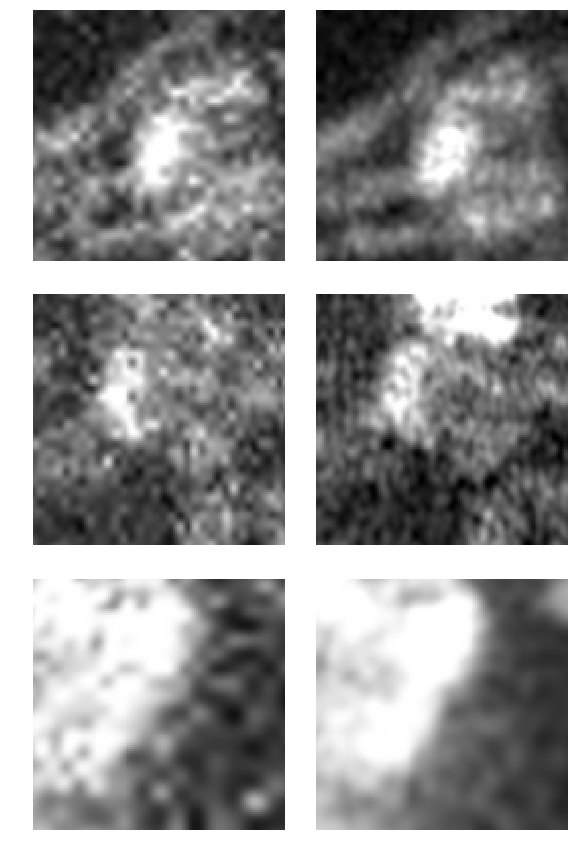

In [5]:
data.show_batch(3)

In [6]:
arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

11916

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [7]:
lr = 1e-3

In [8]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9, cycle_len=10):
    learn.fit_one_cycle(cycle_len, lrs, pct_start=pct_start)
    learn.save(save_name)
    num_rows = min(learn.data.batch_size, 3)
    learn.show_results(rows=num_rows, imgsize=5)

In [ ]:
do_fit('paired_001_unet.0', slice(lr*10))

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('paired_001_unet.1', slice(1e-5,lr))

In [ ]:
bs = 32
size = 256
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('paired_001_unet.1')

In [ ]:
do_fit('paired_001_unet.2', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('paired_001_unet.3', slice(1e-5,lr))

In [ ]:
bs = 4
size = 512
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('paired_001_unet.3')

In [ ]:
do_fit('paired_001_unet.4', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('paired_001_unet.5', slice(1e-5,lr), cycle_len=50)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('paired_001_unet.5')

In [ ]:
do_fit('paired_001_unet.6', lr)

In [ ]:
learn.unfreeze()

In [ ]:
do_fit('paired_001_unet.7', slice(1e-5,lr), cycle_len=50)

In [ ]:
bs = 2
size = 1024
data = get_data(bs, size)

arch = models.resnet34
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=superres_metrics, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()

learn = learn.load('paired_001_unet.6')

In [ ]:
learn.unfreeze()
do_fit('paired_001_unet.8', slice(1e-6,1e-5), cycle_len=10)

In [ ]:
!ls /scratch/bpho/models

In [ ]:
movie_files = list(Path('/scratch/bpho/datasets/movies_001/test').glob('*.czi'))

In [ ]:
fn = movie_files[0]

In [ ]:
with czifile.CziFile(fn) as czi_f:
    proc_axes, proc_shape = get_czi_shape_info(czi_f)
    channels = proc_shape['C']
    depths = proc_shape['Z']
    times = proc_shape['T']
    x,y = proc_shape['X'], proc_shape['Y']
    data = czi_f.asarray()
    preds = []
    origs = []
    idx = build_index(proc_axes, {'T': 0, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
    img = data[idx].astype(np.float32)
    img /= (img.max() * 1.5)

In [ ]:
def image_from_tiles(learn, img, tile_sz=128, scale=4):
    pimg = PIL.Image.fromarray((img*255).astype(np.uint8), mode='L').convert('RGB')
    cur_size = pimg.size
    new_size = (cur_size[0]*scale, cur_size[1]*scale)
    in_img = Image(pil2tensor(pimg.resize(new_size, resample=PIL.Image.BICUBIC),np.float32).div_(255))
    c, w, h = in_img.shape
    
    in_tile = torch.zeros((c,tile_sz,tile_sz))
    out_img = torch.zeros((c,w,h))
    
    for x_tile in range(math.ceil(w/tile_sz)):
        for y_tile in range(math.ceil(h/tile_sz)):
            x_start = x_tile

            x_start = x_tile*tile_sz
            x_end = min(x_start+tile_sz, w)
            y_start = y_tile*tile_sz
            y_end = min(y_start+tile_sz, h)
            
            
            in_tile[:,0:(x_end-x_start), 0:(y_end-y_start)] = in_img.data[:,x_start:x_end, y_start:y_end]
            
            out_tile,_,_ = learn.predict(Image(in_tile))

            out_x_start = x_start
            out_x_end = x_end
            out_y_start = y_start
            out_y_end = y_end

            #print("out: ", out_x_start, out_y_start, ",", out_x_end, out_y_end)
            in_x_start = 0
            in_y_start = 0
            in_x_end = x_end-x_start
            in_y_end = y_end-y_start
            #print("tile: ",in_x_start, in_y_start, ",", in_x_end, in_y_end)
           
            out_img[:,out_x_start:out_x_end, out_y_start:out_y_end] = out_tile.data[:,
                                                                                  in_x_start:in_x_end, 
                                                                                  in_y_start:in_y_end]
    return out_img


In [ ]:
def czi_predict_movie(learn, czi_in, orig_out='orig.tif', pred_out='pred.tif', size=128):
    with czifile.CziFile(czi_in) as czi_f:
        proc_axes, proc_shape = get_czi_shape_info(czi_f)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        times = proc_shape['T']
        x,y = proc_shape['X'], proc_shape['Y']
        data = czi_f.asarray()
        preds = []
        origs = []
        img_max = None
        for t in progress_bar(list(range(times))):
            idx = build_index(proc_axes, {'T': t, 'C': 0, 'Z':0, 'X':slice(0,x),'Y':slice(0,y)})
            img = data[idx].astype(np.float32)
            if img_max is None: img_max = img.max() * 1.0
            img /= img_max
            out_img = image_from_tiles(learn, img, tile_sz=size).permute([1,2,0])
            pred = (out_img[None]*255).cpu().numpy().astype(np.uint8)
            preds.append(pred)
            orig = (img[None]*255).astype(np.uint8)
            origs.append(orig)

        all_y = np.concatenate(preds)
        #print(all_y.shape)
        imageio.mimwrite(pred_out, all_y) #, fps=30, macro_block_size=None) # for mp4
        all_y = np.concatenate(origs)
        #print(all_y.shape)
        imageio.mimwrite(orig_out, all_y) #, fps=30, macro_block_size=None)


In [9]:
bs=1
size=1024
scale = 4

data = get_data(bs, size, tile_size=1024)

wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight, model_dir=model_path)
gc.collect()
learn = learn.load('paired_001_unet.8')


/scratch/bpho/datasets/paired_001/roi_lr_up_1024


In [10]:
learn.export(model_path/'paired_001_unet.8.pkl')
learn = load_learner(model_path, 'paired_001_unet.8.pkl')

In [ ]:
for fn in movie_files:
    pred_name = f'{fn.stem}_pred.tif'
    orig_name = f'{fn.stem}_orig.tif'
    czi_predict_movie(learn, fn, size=size, orig_out=orig_name, pred_out=pred_name )

In [ ]:
learn.pred_batch()